In [518]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors
import umap

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from tabpfn import TabPFNClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

### Data Pull

In [519]:
# load data
train_df = pd.read_csv('icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv('icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv('icr-identify-age-related-conditions/greeks.csv')

# join greeks and add Epsilon
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['EJ', 'Alpha', 'Beta', 'Gamma', 'Delta'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)

# dropping rows with missing values in Epsilon as it helps with class imbalance
# if future data does have this column, it will be important to know if it is missing
train_df = train_df[train_df['Epsilon'].isna() == False].copy()
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])

# change epsilon to months since 1-1-2019 when data started to pick up
train_df['Months Since 1-1-2019'] = (train_df['Epsilon'] - pd.to_datetime('2019-01-01')).dt.days // 30
train_df = train_df.drop('Epsilon', axis = 1)
train_df.reset_index(drop = True, inplace = True)

In [520]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

# Preprocess Data

In [521]:
# set random seed
random_seed = 42
np.random.seed(random_seed)

# pre-process data
y = train_df['Class']
x = train_df.drop(['Id', 'Class'], axis = 1, inplace = False)

# create x and y train
X_train = x.copy()
y_train = y.copy()

# scale and impute data
X_train_columns = X_train.columns
X_train_index = X_train.index
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
knn_imputer = KNNImputer()
X_train = knn_imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_train_columns, index = X_train_index)

# dimension reduction features
umap_n = 3
umap_reducer = umap.UMAP(n_components = umap_n, random_state = random_seed)
umap_columns = ['Component ' + str(i + 1) for i in range(umap_n)]
umap_components = umap_reducer.fit_transform(X_train)
umap_df = pd.DataFrame(data = umap_components, columns = umap_columns, index = X_train_index)
X_train = pd.concat([X_train, umap_df], axis = 1)

In [522]:
# fit knn models for later
knn_cols = [
    'Component 1', 'Component 2', 'Component 3'
]

# save models is a dictionary
knn_models_list = [5, 7, 11]
knn_models_dict = {}
for n in knn_models_list:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(X_train[knn_cols], y_train)
    knn_models_dict[n] = knn

In [523]:
# iterate through each row and predict using knn
knn_train_df = X_train[knn_cols]
knn_train_df['Class'] = y_train
knn_target = 'Class'

knn_predictions = {}
for n in knn_models_list:
    knn_predictions[n] = []
    
for i in range(len(knn_train_df)):
    row_train = knn_train_df.drop(i)
    row = knn_train_df.loc[i].to_frame().T
    
    row_y = row_train[knn_target]
    row_train = row_train.drop([knn_target], axis = 1)
    row = row.drop([knn_target], axis = 1)

    scaler = StandardScaler()
    row_train = scaler.fit_transform(row_train)
    row = scaler.transform(row)
    
    for n in knn_models_list:
        knn = KNeighborsClassifier(n_neighbors = n)
        knn.fit(row_train, row_y)
        knn_predictions[n].append(knn.predict_proba(row)[0][1])

for n in knn_models_list:
    col_name = 'knn_' + str(n)
    X_train[col_name] = np.array(knn_predictions[n])

In [524]:
print('Shape of X:', X_train.shape)
print('Shape of y:', y_train.shape)

Shape of X: (473, 62)
Shape of y: (473,)


# Modeling

In [456]:
def evaluate_model_performance(y_true, x, model):
    pred = model.predict(x)
    pred_proba = model.predict_proba(x)[:, 1]
    
    roc_auc = roc_auc_score(y_true, pred_proba)
    accuracy = accuracy_score(y_true, pred)
    precision = precision_score(y_true, pred)
    recall = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    
    print(f"ROC AUC Score: {roc_auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return roc_auc, accuracy, precision, recall, f1

In [457]:
def find_nearest_neighbors(df, row, n_neighbors):
    if row > len(df):
        raise ValueError('Row index is greater than the number of rows in the dataframe.')
    
    if row < 0:
        raise ValueError('Row index is less than 0.')
    
    knn_df = df.drop('Class', axis = 1)
    knn_columns = knn_df.columns
    knn_index = knn_df.index
    knn_df = StandardScaler().fit_transform(knn_df)
    knn_df = pd.DataFrame(knn_df, columns = knn_columns, index = knn_index)
    knn = NearestNeighbors(n_neighbors = n_neighbors).fit(knn_df)
    
    distances, indices = knn.kneighbors(knn_df.loc[row, :].values.reshape(1, -1))
    
    distances = np.array(distances)
    neighbors = distances.argsort()[:n_neighbors]
    
    return df.iloc[indices[0], :]

Gradient Boosting (Baseline)

In [458]:
np.random.seed(random_seed)
gb = GradientBoostingClassifier(random_state = random_seed)

parameters = {
    'loss': ['log_loss'],
    'learning_rate': [0.2],
    'n_estimators': [500],
    'criterion': ['friedman_mse'],
    'max_depth': [3],
    'min_samples_leaf': [4],
    'min_samples_split': [4],
    'max_features': [None]
}

grid_obj = GridSearchCV(gb, parameters, scoring = 'roc_auc', cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)
gb = grid_obj.best_estimator_
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=4,
                           min_samples_split=4, n_estimators=500,
                           random_state=42)

In [459]:
# view results of grid search
gb_results = pd.DataFrame(grid_obj.cv_results_)
gb_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_learning_rate,param_loss,param_max_depth,param_max_features,param_min_samples_leaf,...,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.138626,0.047299,0.001968,0.000038,friedman_mse,0.2,log_loss,3,None,4,...,500,"{'criterion': 'friedman_mse', 'learning_rate':...",0.978207,0.936488,0.932752,0.956295,0.949119,0.950572,0.016214,1


In [460]:
# print results of roc auc score
print('ROC AUC Score:', np.round(gb_results['mean_test_score'].max(), 4))

ROC AUC Score: 0.9506


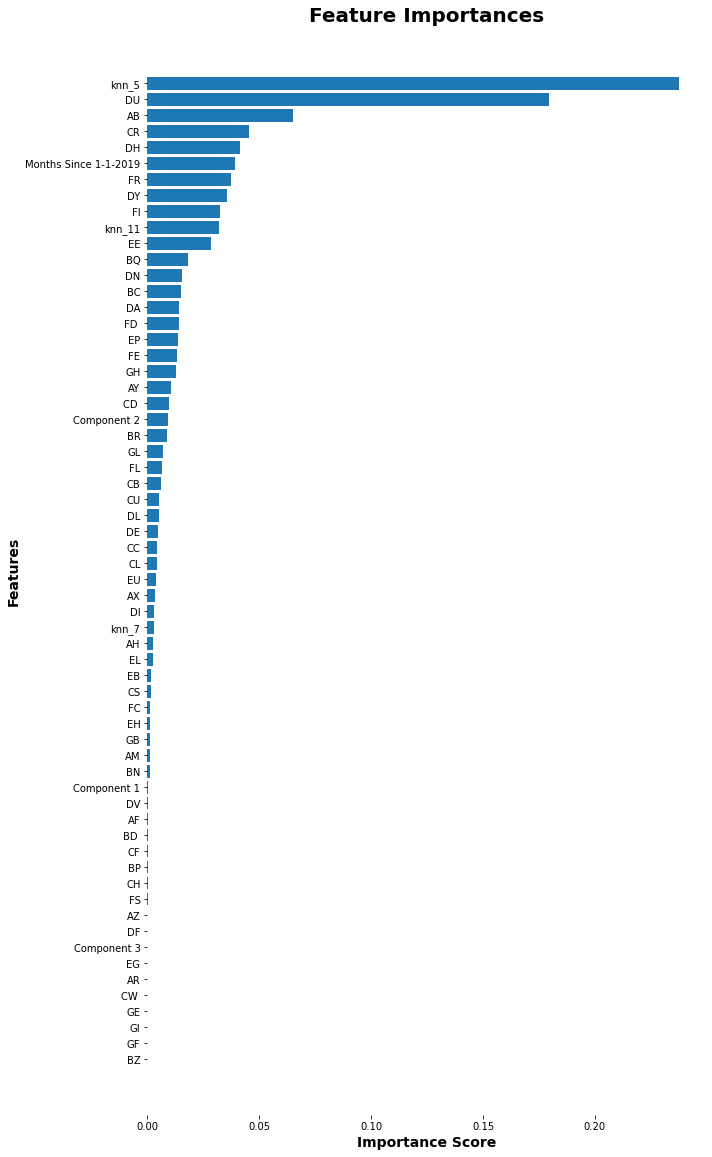

In [461]:
# Create a pandas series with features importances and sort it
importances = pd.Series(gb.feature_importances_, index = X_train.columns).sort_values(ascending = True)

# Plot feature importances
plt.figure(figsize = (10, 20))
plt.title('Feature Importances', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

TabPFN

In [462]:
np.random.seed(random_seed)
tpfn = TabPFNClassifier()

parameters = {
    'N_ensemble_configurations': [10],
    'batch_size_inference': [32],
    'device': ['cpu'],
    'multiclass_decoder': ['permutation'],
    'seed': [random_seed]
}

grid_obj = GridSearchCV(tpfn, parameters, scoring = 'roc_auc', cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)
tpfn = grid_obj.best_estimator_
tpfn.fit(X_train, y_train)

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


TabPFNClassifier(N_ensemble_configurations=10, seed=42)

In [463]:
# view results of grid search
tpfn_results = pd.DataFrame(grid_obj.cv_results_)
tpfn_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_N_ensemble_configurations,param_batch_size_inference,param_device,param_multiclass_decoder,param_seed,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001167,0.000062,0.754238,0.014921,10,32,cpu,permutation,42,"{'N_ensemble_configurations': 10, 'batch_size_...",0.978829,0.970735,0.909091,0.942596,0.940639,0.948378,0.024754,1


In [464]:
# print results of roc auc score
print('ROC AUC Score:', np.round(tpfn_results['mean_test_score'].max(), 4))

ROC AUC Score: 0.9484


SVM

In [465]:
np.random.seed(random_seed)
svm = SVC(random_state = random_seed, probability=True)

parameters = {
    'kernel': ['rbf'],
    'C': [10],
    'gamma': [0.01],
    'random_state': [random_seed],
    'probability': [True],
    'cache_size': [10000],
}

grid_obj = GridSearchCV(svm, parameters, scoring = 'roc_auc', cv = 5)
grid_obj = grid_obj.fit(X_train, y_train)
svm = grid_obj.best_estimator_
svm.fit(X_train, y_train)

SVC(C=10, cache_size=10000, gamma=0.01, probability=True, random_state=42)

In [466]:
# view results of grid search
svm_results = pd.DataFrame(grid_obj.cv_results_)
svm_results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_cache_size,param_gamma,param_kernel,param_probability,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019729,0.001301,0.003046,0.00049,10,10000,0.01,rbf,True,42,"{'C': 10, 'cache_size': 10000, 'gamma': 0.01, ...",0.965131,0.968244,0.907223,0.902805,0.917808,0.932242,0.028561,1


In [467]:
# print results of roc auc score
print('ROC AUC Score:', np.round(svm_results['mean_test_score'].max(), 4))

ROC AUC Score: 0.9322


In [468]:
def model_cross_validation(X, y, models, model_names, n_splits = 5):
    skf = StratifiedKFold(n_splits = n_splits, random_state = random_seed, shuffle = True)
    
    # create dataframe to hold results
    results_df = pd.DataFrame(columns = ['Model', 'Fold', 'Accuracy', 'ROC_AUC'])
    
    for sampling_strategy in ['None', 'SMOTE', 'RandomOverSampler']:
        for i, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            if sampling_strategy == 'SMOTE':
                X_train, y_train = SMOTE(random_state = random_seed).fit_resample(X_train, y_train)
            elif sampling_strategy == 'RandomOverSampler':
                X_train, y_train = RandomOverSampler(random_state = random_seed).fit_resample(X_train, y_train)
            elif sampling_strategy == 'RandomUnderSampler':
                X_train, y_train = RandomUnderSampler(random_state = random_seed).fit_resample(X_train, y_train)
            else:
                pass
                
        
            for model, model_name in zip(models, model_names):
                if sampling_strategy == 'None':
                    model_name = model_name
                else:
                    model_name = model_name + ' with ' + sampling_strategy
                
                print(model_name, 'Fold', i + 1)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]
                
                accuracy = accuracy_score(y_test, y_pred)
                roc_auc = roc_auc_score(y_test, y_proba)
                
                new_result_index = len(results_df)
                new_results_row = pd.DataFrame({
                    'Model': model_name, 
                    'Fold': i + 1, 
                    'Accuracy': accuracy, 
                    'ROC_AUC': roc_auc
                }, index = [new_result_index])
                
                results_df = pd.concat([results_df, new_results_row])
            
            # average predictions
            avg_pred = np.mean([model.predict_proba(X_test)[:, 1] for model in models], axis = 0)
            
            avg_accuracy = accuracy_score(y_test, np.round(avg_pred))
            avg_roc_auc = roc_auc_score(y_test, avg_pred)
            
            new_result_index = len(results_df)
            if sampling_strategy == 'None':
                model_name = 'Average'
            else:
                model_name = 'Average' + ' with ' + sampling_strategy
            new_results_row = pd.DataFrame({
                'Model': model_name, 
                'Fold': i + 1, 
                'Accuracy': avg_accuracy, 
                'ROC_AUC': avg_roc_auc
            }, index = [new_result_index])
        
            results_df = pd.concat([results_df, new_results_row])
            print()
        
    return results_df

In [469]:
gb_model = GradientBoostingClassifier(learning_rate = 0.2, min_samples_leaf = 4,min_samples_split = 4, n_estimators = 500, random_state = random_seed)
tpfn_model = TabPFNClassifier(N_ensemble_configurations = 10, seed = random_seed)
svm_model = SVC(C = 10, gamma = 0.01, probability = True, random_state = random_seed)

models = [gb_model, tpfn_model]
model_names = ['Gradient Boosting', 'TabPFN']

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [470]:
cv_results = model_cross_validation(X_train, y_train, models, model_names)

Gradient Boosting Fold 1
TabPFN Fold 1

Gradient Boosting Fold 2
TabPFN Fold 2

Gradient Boosting Fold 3
TabPFN Fold 3

Gradient Boosting Fold 4
TabPFN Fold 4

Gradient Boosting Fold 5
TabPFN Fold 5

Gradient Boosting with SMOTE Fold 1
TabPFN with SMOTE Fold 1

Gradient Boosting with SMOTE Fold 2
TabPFN with SMOTE Fold 2

Gradient Boosting with SMOTE Fold 3
TabPFN with SMOTE Fold 3

Gradient Boosting with SMOTE Fold 4
TabPFN with SMOTE Fold 4

Gradient Boosting with SMOTE Fold 5
TabPFN with SMOTE Fold 5

Gradient Boosting with RandomOverSampler Fold 1
TabPFN with RandomOverSampler Fold 1

Gradient Boosting with RandomOverSampler Fold 2
TabPFN with RandomOverSampler Fold 2

Gradient Boosting with RandomOverSampler Fold 3
TabPFN with RandomOverSampler Fold 3

Gradient Boosting with RandomOverSampler Fold 4
TabPFN with RandomOverSampler Fold 4

Gradient Boosting with RandomOverSampler Fold 5
TabPFN with RandomOverSampler Fold 5

Gradient Boosting with RandomUnderSampler Fold 1
TabPFN with

In [471]:
results = cv_results.drop('Fold', axis = 1).groupby('Model').mean()

In [472]:
results['Accuracy Z Score'] = (results['Accuracy'] - results['Accuracy'].mean()) / results['Accuracy'].std()
results['ROC AUC Z Score'] = (results['ROC_AUC'] - results['ROC_AUC'].mean()) / results['ROC_AUC'].std()
results['Average Z Score'] = results[['Accuracy Z Score', 'ROC AUC Z Score']].mean(axis = 1)
results.sort_values('Average Z Score', ascending = False)

,Accuracy,ROC_AUC,Accuracy Z Score,ROC AUC Z Score,Average Z Score
Model,,,,,
Average with SMOTE,0.936529,0.959776,1.107921,1.186692,1.147307
Gradient Boosting with SMOTE,0.928018,0.961952,0.753585,1.477537,1.115561
Gradient Boosting with RandomOverSampler,0.930213,0.960232,0.844967,1.247714,1.046340
Average with RandomOverSampler,0.930190,0.954694,0.844034,0.507526,0.675780
TabPFN with SMOTE,0.921769,0.951818,0.493428,0.123167,0.308297
Average,0.917536,0.950246,0.317193,-0.086844,0.115174
TabPFN with RandomOverSampler,0.913326,0.950667,0.141890,-0.030577,0.055656
Gradient Boosting,0.909071,0.949973,-0.035278,-0.123299,-0.079288
TabPFN,0.915431,0.947079,0.229541,-0.510035,-0.140247


Submission

In [480]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, min_samples_leaf=4,
                           min_samples_split=4, n_estimators=500,
                           random_state=42)

In [487]:
X_train

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GB,GE,GF,GH,GI,GL,Months Since 1-1-2019,Component 1,Component 2,Component 3
0,-0.558848,-0.236450,-0.269977,-0.246707,-0.218848,-1.827988,-0.081263,-0.182438,-0.052735,-0.395860,...,-0.929947,-0.408672,-0.655369,-0.893790,0.503464,-0.760123,-0.434323,2.226851,11.619739,7.621610
1,-0.225481,0.014720,-0.269977,-0.353351,-0.218848,-0.590782,-0.019649,-1.699753,1.248230,0.083465,...,-0.442469,0.068401,-0.297474,1.432582,-0.426912,-0.762454,0.526775,2.932274,11.954643,7.493268
2,-0.558848,-0.434973,-0.269977,-0.424898,-0.218848,-0.563739,-0.081263,0.464433,-0.110995,-0.063489,...,0.087048,-0.408672,0.561687,-0.254382,0.855214,1.387027,0.126318,2.010786,14.731083,7.372338
3,-0.287987,-0.790047,-0.269977,-0.427010,0.564196,-1.364881,-0.081263,-0.954510,-0.110995,0.077998,...,-0.301146,0.369209,-0.582443,0.310174,1.341820,-0.765550,-0.274140,1.598144,12.587306,7.499876
4,-0.442170,-1.098849,-0.269977,-0.262403,-0.218848,-0.191901,-0.081263,-0.277829,-0.110995,-0.122355,...,-0.246584,-0.167971,0.407682,0.414445,-0.560983,-0.762822,-0.354231,3.288703,11.520083,7.336023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-0.625522,-0.438413,-0.269977,-0.443861,-0.218848,-0.556978,-0.081263,-1.699753,-0.110995,0.391235,...,-0.394169,0.717381,-0.163769,0.731915,-0.295406,1.387027,0.767050,1.966031,13.314116,8.447943
469,-0.675527,-0.227986,0.071075,-0.412389,0.314057,-0.759799,0.027845,-0.482026,-0.089792,-0.386557,...,-1.158033,0.529504,-0.320990,-0.643166,0.485644,1.387027,1.007324,1.442425,14.486184,7.480410
470,-0.117137,0.710646,-0.269977,0.064023,0.636319,0.186698,-0.080621,0.482319,-0.076683,0.061129,...,1.431413,2.345951,-0.596009,-0.141918,2.026932,-0.757668,1.007324,1.335232,12.587315,8.486352
471,-0.133805,-0.498048,0.127455,0.177279,-0.015074,0.984460,-0.081263,1.141114,-0.110995,0.131376,...,-0.100788,-0.043327,-0.409977,-0.490482,1.881457,1.387027,-0.113957,2.220012,13.397289,8.500677


In [530]:
def prediction_pipeline(x):
    x = x.select_dtypes(include = [np.number])
    x['Months Since 1-1-2019'] = [X_train['Months Since 1-1-2019'].max() + 1] * len(x)
    
    X_columns = x.columns
    X_index = x.index
    
    x = standard_scaler.transform(x)
    x = knn_imputer.transform(x)
    x = pd.DataFrame(x, columns = X_columns, index = X_index)
    
    umap_components = umap_reducer.transform(x)
    umap_df = pd.DataFrame(data = umap_components, columns = umap_columns, index = X_index)
    x = pd.concat([x, umap_df], axis = 1)
    
    for n in knn_models_list:
        knn_predictions = knn_models_dict[n].predict_proba(x[knn_cols])[0][1]
        x['knn_' + str(n)] = knn_predictions
        
    model_data, model_responce = SMOTE(random_state = random_seed).fit_resample(X_train, y_train)
    gb_model.fit(model_data, model_responce)
    tpfn_model.fit(model_data, model_responce)
    
    gb_prediction = gb_model.predict_proba(x)
    tpfn_prediction = tpfn_model.predict_proba(x)
    average_prediction = np.mean([gb_prediction, tpfn_prediction], axis = 0)
    
    x['class_0'] = average_prediction[:, 0]
    x['class_1'] = average_prediction[:, 1]
        
    return x

In [534]:
X_test = prediction_pipeline(test_df)

In [537]:
submission_df = test_df[['Id']]
predictions = X_test[['class_0', 'class_1']]
submission_df = pd.concat([submission_df, predictions], axis = 1)

In [ ]:
submission_df.to_csv('/kaggle/working/submission.csv', index = False)